In [1]:
import os, fnmatch
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, LSTM, Dropout, \
    Lambda, Input, Multiply, Layer, Conv1D, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger, \
    EarlyStopping, ModelCheckpoint
import tensorflow as tf
import soundfile as sf
import math
from wavinfo import WavInfoReader
from random import shuffle, seed
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from scipy import signal
from scipy.signal import butter, lfilter

E:\conda\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
E:\conda\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
E:\conda\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
audio_file_name='E:/intern/codes/dataset/RIR/small_room/Room001-00001.wav'
in_data2,fs = sf.read(audio_file_name)

In [ ]:
plt.plot(in_data2)

In [4]:
def rms(audio):
    v_rms = (audio ** 2).mean() ** 0.5
    return v_rms

In [5]:
def amp_to_dB(audio):
    v_rms = rms(audio)
    print(v_rms)

In [6]:
def normalize(audio):
    norm_audio = audio / np.max(np.abs(audio))
    return norm_audio

In [7]:
def process_rir(rir):
    norm_Rir=normalize(rir)
    gain=np.random.uniform(-25,0)
    temp=add_gain(norm_Rir,gain)
    temp[np.argmax(temp,axis=0)]=1
    return temp

In [ ]:
amp_to_dB(in_data1)

In [ ]:
norm_Rir=normalize(in_data2)

In [ ]:
amp_to_dB(norm_Rir)

In [ ]:
plt.plot(norm_Rir)

In [8]:
def add_gain(audio,gain):
    new_audio=audio*(10**(gain/20))
    return new_audio

In [ ]:
gain=np.random.uniform(-25,0)

In [ ]:
temp=add_gain(norm_Rir,gain)
temp[np.argmax(temp,axis=0)]=1
plt.plot(temp)

In [9]:
def add_noise(signal,noise_SNR,spectral_shaping=False):
    RMS=math.sqrt(np.mean(signal**2))
    STD_n=RMS/(10**(noise_SNR/20))
    noise=np.random.normal(0, STD_n, signal.shape[0])
    if spectral_shaping:
        noise=random_spectral_shaping(noise)
    signal_noise = signal+noise
    return signal_noise

In [ ]:
plt.plot(in_data1)

In [ ]:
noise_SNR=np.random.normal(5,10,1)

In [ ]:
noise_SNR

In [ ]:
noisy_audio=add_noise(in_data1,noise_SNR)

In [ ]:
plt.plot(noisy_audio)

In [ ]:
sf.write('noisy.wav', noisy_audio,fs)

In [10]:
def add_delay(audio,fs,time):
    # time in ms
    delay=int(time*fs/1000)
    delayed_audio=np.zeros(np.shape(audio))
    delayed_audio[delay:]=audio[delay:]
    return delayed_audio

In [11]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [12]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [13]:
def conv_RIR(audio,rir):
    signal_rev =signal.fftconvolve(audio,rir,mode="full")
    signal_rev = signal_rev[0 : audio.shape[0]]
    return signal_rev

In [14]:
def random_spectral_shaping(audio):
    r=np.random.uniform(-3/8,3/8,4)
    b=[1,r[0],r[1]]
    a=[1,r[2],r[3]]
    y = lfilter(b, a, audio)
    return y

In [15]:
def discard(audio,fs):
    z=np.random.uniform(0,1,1)
    start=np.random.randint(0,fs*2-2)
    if z<0.5:
        end=start+fs
        discarded_audio=audio
        discarded_audio[start:end]=0
    else:
        end=start+2*fs
        discarded_audio=audio
        discarded_audio[start:end]=0
    return discarded_audio,start,end

In [ ]:
r_audio=random_spectral_shaping(noisy_audio)

In [ ]:
fil_audio=butter_bandpass_filter(noisy_audio,200,7000,fs)

In [ ]:
plt.plot(fil_audio)

In [ ]:
plt.plot(r_audio)

In [ ]:
plt.plot(noisy_audio)

In [ ]:
sf.write('r_audio.wav', r_audio,fs)

In [16]:
def add_signals(audio1,audio2,snr):
    # add 2 signals with given snr ratio
    rms1=rms(audio1)
    rms2=rms(audio2)
    scaler=rms1/(rms2*(10**(snr/20)))
    scaled_audio2=scaler*audio2
    y=audio1+scaled_audio2
    return y

In [ ]:
audio_file_name='E:/intern/codes/dataset/farend_signal/farend_speech_fileid_1.wav'
in_data1,fs = sf.read(audio_file_name)

In [ ]:
a=in_data1[:64000]
b=noisy_audio[:64000]

In [ ]:
snr=np.random.normal(0, 10,1)
final=add_signals(a,b,snr)

In [ ]:
sf.write('add.wav', final,fs)

In [17]:
def create_farend_signal(farend,rir,fs):
    ##################################################################################
    #create farend signal from farend speech and farend room impulse response 
    ##################################################################################    

    # The echo signal is convolved with IR of Far-end room.
    
    processed_rir=process_rir(rir)
    room_farend=conv_RIR(farend,processed_rir)
    
    # In 50% of the cases, a noise sample is added with an SNR randomly taken from a 
    # normal distribution with a mean 5 dB and standard deviation 10 dB to account for
    # a noisy far-end signal.
    
    z=np.random.uniform(0,1,1)
    if z>0.5:
        noise_SNR=np.random.normal(5,10,1)
        noisy_farend=add_noise(room_farend,noise_SNR)
    else:
        noisy_farend=room_farend
    
    return noisy_farend

In [18]:
def create_nearend_signal(nearend,rir,fs):
    ##################################################################################
    #create nearend signal from nearend speech and nearend room impulse response 
    ##################################################################################
    
    # The echo signal is convolved with IR of near-end room.
    processed_rir=process_rir(rir)
    room_nearend=conv_RIR(nearend,processed_rir)
    
    # Random spectral shaping for noise reduction is applied to the speech signal to 
    # increase robustness and model various transmission effects.
    
    spectral = random_spectral_shaping(room_nearend)
    
    # In 70% of the cases, a noise sample is added with an SNR randomly taken from a
    # normal distribution with a mean 5 dB and standard deviation 10 dB to account for
    # a noisy far-end signal. Random spectral shaping is also applied to the noise 
    # signal independently.
    
    z=np.random.uniform(0,1,1)
    if z>0.3:
        noise_SNR=np.random.normal(5,10,1)
        noisy_nearend=add_noise(room_nearend,noise_SNR,spectral_shaping = True)
    else:
        noisy_nearend=room_nearend
    
    return noisy_nearend

In [19]:
def create_echo_signal(farend,rir,fs):
    ##################################################################################
    #create echo signal from farend and room impulse response used in near end signal
    ##################################################################################
        
    # the previously created far-end signal is delayed by a random value between 10 
    # and 100 ms to simulate a processing and transmission delay
    
    delay=np.random.uniform(10,100,1)
    delayed_audio = add_delay(farend,fs,delay)
    
    # The delayed signal is filtered by a band-pass signal with a random lower cut-off
    # frequency between 100 and 400 Hz and a higher cut-off frequency between 6000 and
    # 7500 Hz.
    
    low=np.random.uniform(100,400,1)
    high=np.random.uniform(6000,7500,1)
    fil_audio=butter_bandpass_filter(delayed_audio,low,high,fs)
    
    # The echo signal is finally convolved with same IR as the near-end signal.
    
    processed_rir=process_rir(rir)
    echo=conv_RIR(fil_audio,processed_rir)
    plt.figure(2)
    plt.plot(farend)
    plt.plot(echo)
    return echo

In [29]:
def preprocess(nearend,farend,rir_nearend,rir_farend,fs):
    ##################################################################################
    #create inputs and output for the model
    ##################################################################################
    flag=0
    
    # In 5% of the cases, a near-end speech segment of random duration
    # is discarded to account for far-end-only scenarios
    z=np.random.uniform(0,1,1)
    if z<0.05:
        flag=1
        discarded_nearend_speech,start,end=discard(nearend,fs)
    else:
        discarded_nearend_speech=nearend
    
    # In 90% of the cases, the echo signal is added to the near-end speech with a 
    # speechto-echo ratio taken from a normal distribution with a 0 dB mean and 
    # standard deviation of 10 dB.. The echo signal as well as the far-end speech 
    # signal is applied with random spectral shaping.If no echo is applied, the far-end 
    # signal is set to zero or to low-level noise in the range between -70 and -120 dB 
    # RMS with random spectral shaping.
    
    nearend_speech_sig = create_nearend_signal(discarded_nearend_speech,rir_nearend,fs)
    z=np.random.uniform(0,1,1)
    if z>0.1:
        print('echo')
        farend_signal = create_farend_signal(farend,rir_farend,fs)
        echo = create_echo_signal(farend_signal,rir_farend,fs)
        farend_signal = random_spectral_shaping(farend_signal)
        echo = random_spectral_shaping(echo)
        ser = np.random.uniform(0,10,1)
        nearend_sig = add_signals(nearend_speech_sig,echo,ser)
        return nearend_sig,farend_signal,discarded_nearend_speech
    else:
        print('no echo')
        p=np.random.uniform(0,1,1)
        if p>0.5:
            farend_signal=np.zeros(nearend.shape[0])
            return nearend_speech_sig,farend_signal,discarded_nearend_speech
        else:
            STD_n = np.random.uniform(-70,-120,1)
            farend_signal = np.random.normal(0, STD_n, nearend.shape[0])
            farend_signal = random_spectral_shaping(farend_signal)
            return nearend_speech_sig,farend_signal,discarded_nearend_speech

In [30]:
audio_file_name='E:/intern/codes/dataset/farend_speech/farend_speech_fileid_0.wav'
farend,fs = sf.read(audio_file_name)
audio_file_name='E:/intern/codes/dataset/nearend_speech/nearend_speech_fileid_0.wav'
nearend,fs = sf.read(audio_file_name)
audio_file_name='E:/intern/codes/dataset/RIR/large_room/RVB2014_type1_rir_largeroom1_far_anglb.wav'
farend_rir,fs = sf.read(audio_file_name)
audio_file_name='E:/intern/codes/dataset/RIR/small_room/Room001-00001.wav'
nearend_rir,fs = sf.read(audio_file_name)

In [31]:
farend_chunk=farend[64000:128000]
nearend_chunk=nearend[64000:128000]
sf.write('farend_chunk.wav', farend_chunk, fs)
sf.write('nearend_chunk.wav', nearend_chunk, fs)

In [32]:
nearend_sig,farend_signal,discarded_nearend_speech=preprocess(nearend_chunk,farend_chunk,nearend_rir,farend_rir,fs)

no echo


ValueError: scale < 0

In [120]:
in_data2=in_data2[:,0]

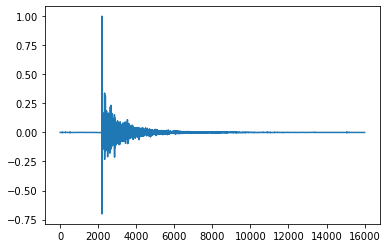

In [121]:
plt.plot(in_data2)

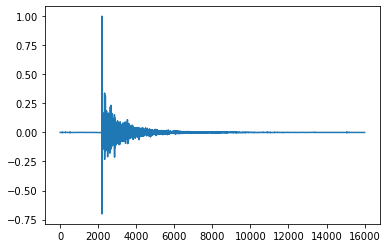

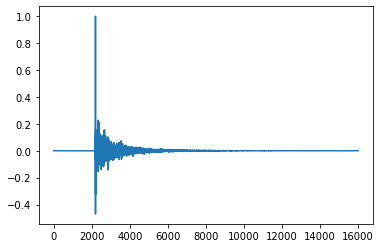

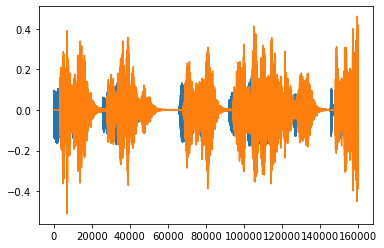

In [127]:
echo = create_echo_signal(in_data1,in_data2,fs)

In [128]:
sf.write('echo.wav', echo,fs)

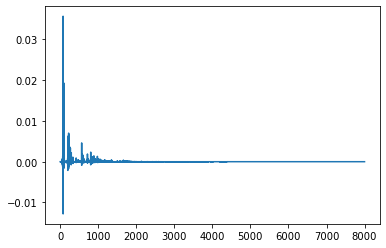

In [33]:
a=[1,2,3,4,5]

In [34]:
shuffle(a)

In [36]:
import pandas as pd

ModuleNotFoundError: No module named 'pandas'